# Interpret trained following model

In [1]:
# Imports
import torch
import pickle
from pathlib import Path
from lambeq.backend.quantum import Diagram as Circuit, qubit, Id, Discard, Ket
from lambeq.backend.grammar import Diagram, Ty
import matplotlib.pyplot as plt

from utils.following.parser import FollowingParser
from utils.ansatz import DaggerableSim4Ansatz
from utils.visualize_quantum import (
    get_bloch_points, plot_points,
    get_sphere_colours, display_2q_state,
    get_remote_prep_marker_states, display_1q_rotation,
    eigenteroterpolate, get_remote_prep_states,
)

SAVE_DIR = Path("./results/").resolve()
SAVE_DIR

PosixPath('/Users/tiffany.duneau/PycharmProjects/QDisCoCirc_Following_Showcase/tutorials/results')

In [2]:
# Select the number of directions the model has
DIRS = 4
MODEL_NAME = f"{DIRS}-dir model"

### Get trained boxes
This is setup to flow seamlessly from the training notebook - if the ansatz and dataset settings were changedm these should be updated here too.

In [3]:
# load the saved weights
with open(SAVE_DIR / "training" / "model.lt", "rb") as f:
    checkpoint = pickle.load(f)

symbols = checkpoint["model_symbols"]
weights = checkpoint["model_weights"].detach().numpy()
len(symbols), len(weights), weights

(72,
 72,
 array([ 0.7803903 ,  0.18207695,  0.96444875,  0.12581007,  0.3382352 ,
         0.14858927,  0.913195  ,  0.71166706,  0.23019427,  0.12168668,
         0.24621809,  0.3690374 ,  0.22284359,  0.8331805 ,  0.26637214,
         0.16216788,  0.38807198, -0.01580531,  0.27005044,  0.21775141,
         0.5860302 ,  0.88429093,  0.5895187 ,  0.23186508,  0.69303834,
         0.32085946,  0.2491447 ,  0.43792242,  0.21455741,  0.56796515,
         0.87115026,  0.57116807,  0.79949015,  0.07740886,  0.11220626,
         0.44411275,  0.5140148 ,  0.80645025,  0.06758053,  0.74073464,
         0.0814177 ,  0.5505416 ,  0.83301026,  0.5879929 ,  0.6646313 ,
         0.842878  ,  0.9912662 ,  0.18284473,  0.6630856 ,  0.8839794 ,
         0.7874589 ,  0.02385519,  0.1620371 ,  0.00948433,  0.7262194 ,
         0.9997736 ,  0.02059499,  0.929809  ,  0.01398357,  0.46893507,
         0.90742916,  0.42901108,  0.552013  ,  0.83920085,  0.07338163,
         0.6085466 ,  0.25628808,  0.9547

In [4]:
parser = FollowingParser(with_axioms=True, n_directions=4)
ansatz = DaggerableSim4Ansatz(
    ob_map={Ty('n'): 1},
    n_layers=3,
    discard=True,
    n_ancillas={parser.follows: 1, parser.goes_opdir: 1},
)
convert = lambda diag: ansatz(diag).lambdify(*symbols)(*weights)

In [5]:
person = convert(parser.person)

walks_north  = convert(parser.walks_north)
walks_south  = convert(parser.walks_south)
turns_around = convert(parser.turns_around)

if DIRS == 4:
    walks_east  = convert(parser.walks_east)
    walks_west  = convert(parser.walks_west)
    turns_left   = convert(parser.turns_left)
    turns_right  = convert(parser.turns_right)

follows = convert(parser.follows)
goes_opdir = convert(parser.goes_opdir)

goes_in_same_dir_as = convert(parser.get_ques_diag(negative=False, nouns=True, higher_order=False))
goes_not_in_same_dir_as = convert(parser.get_ques_diag(negative=True, nouns=True, higher_order=False))

person @ walks_north @ walks_south @ turns_around


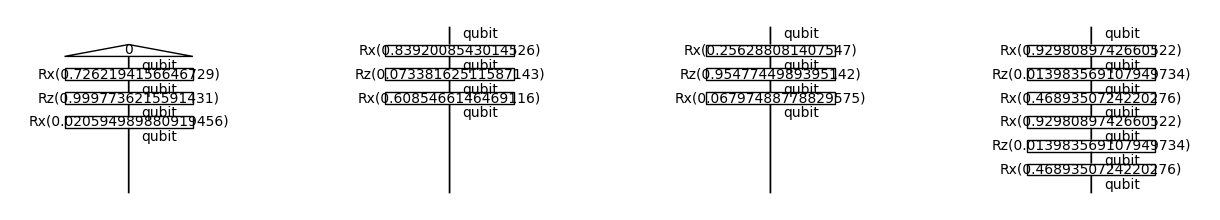

turns_left @ turns_right @ walks_east @ walks_west


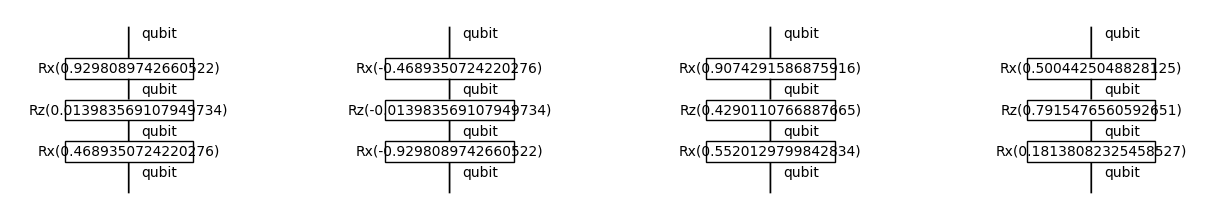

follows @ goes_opdir


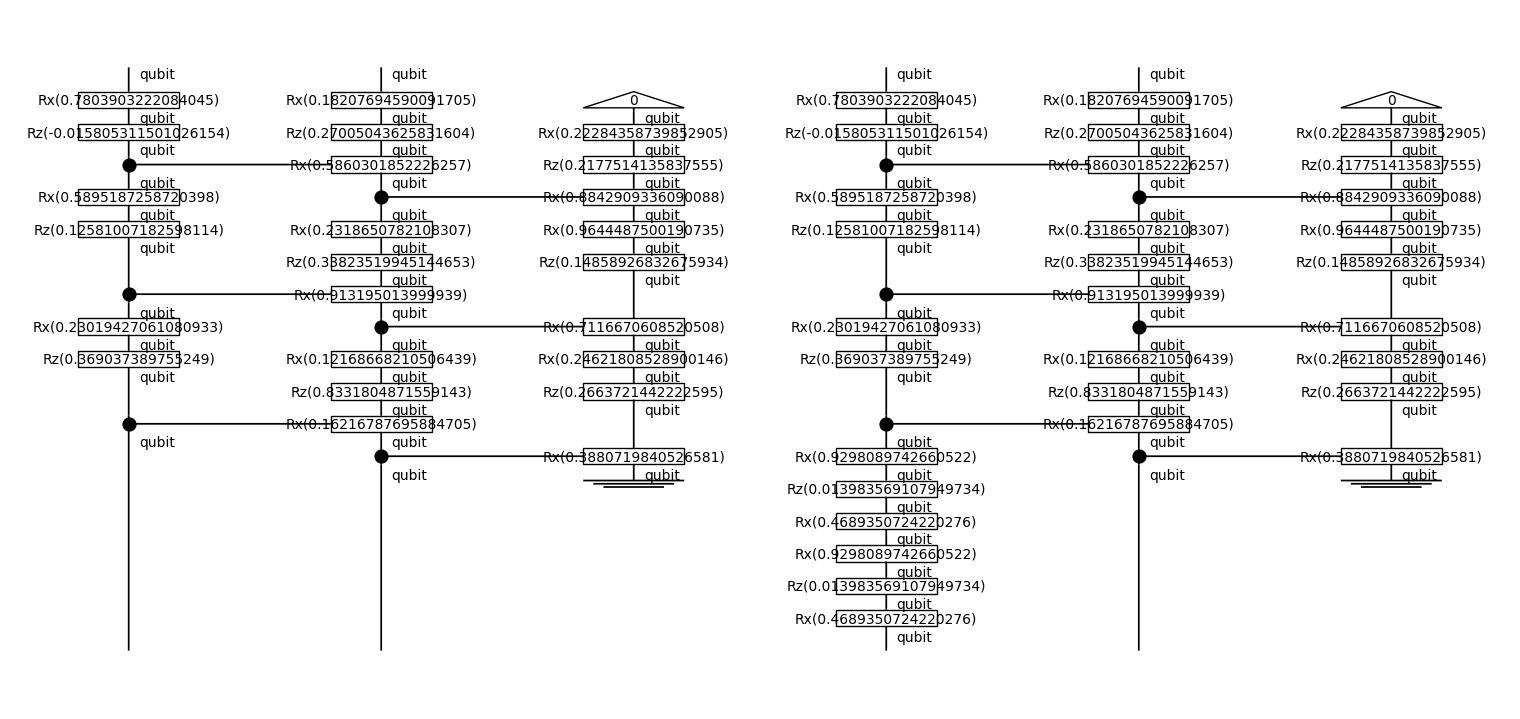

QUESTIONS
goes_in_same_dir_as @ goes_not_in_same_dir_as


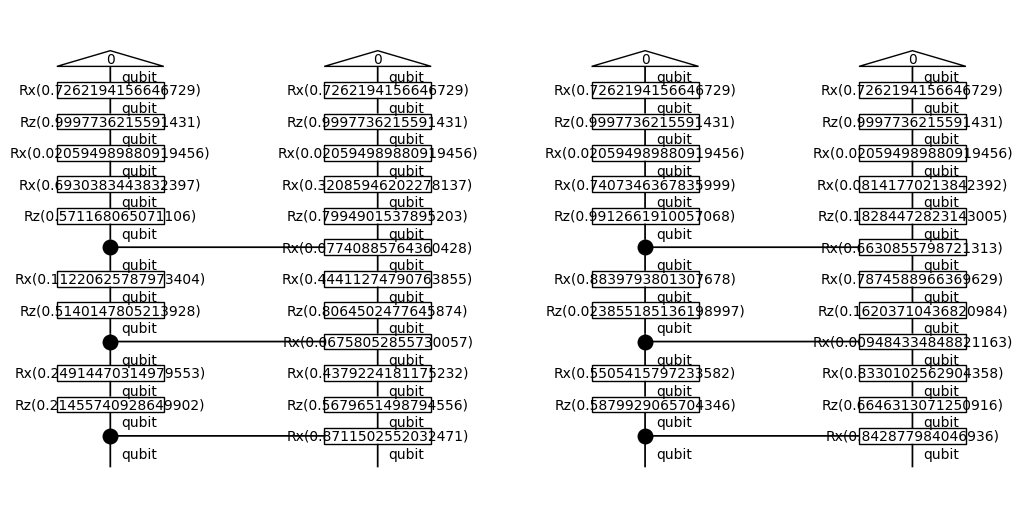

In [14]:
# Draw the circuits out
print("person @ walks_north @ walks_south @ turns_around")
(person @ walks_north @ walks_south @ turns_around).draw(figsize=(12,2 if DIRS == 4 else 4))
if DIRS == 4:
    print("turns_left @ turns_right @ walks_east @ walks_west")
    (turns_left @ turns_right @ walks_east @ walks_west).draw(figsize=(12,2))

print("follows @ goes_opdir")
(follows @ goes_opdir).draw(figsize=(15,7))

print("QUESTIONS")
print("goes_in_same_dir_as @ goes_not_in_same_dir_as")
(goes_in_same_dir_as @ goes_not_in_same_dir_as).draw(figsize=(10,5))

In [6]:
def lambdeval(diag):
    return torch.as_tensor(diag.eval())

lambdeval(person)

tensor([6.9999e-01+4.2813e-04j, 5.6789e-04+7.1415e-01j],
       dtype=torch.complex128)

## Plots!

In [7]:
cardinal_cols = {
    walks_north: "#ff3333",
    walks_east: "#ffcc33",
    walks_south: "#33ff33",
    walks_west: "#33ccff",
}
get_text = {
    walks_north: "North",
    walks_south: "South",
    walks_east: "East",
    walks_west: "West",
    turns_left: "left",
    turns_right: "right",
    turns_around: "around",
}
get_annotation = {
    person: "|Person⟩",
    walks_north: "|North⟩",
    walks_east: "|East⟩",
    walks_south: "|South⟩",
    walks_west: "|West⟩",
}

ValueError: 'c' argument has 5 elements, which is inconsistent with 'x' and 'y' with size 2.

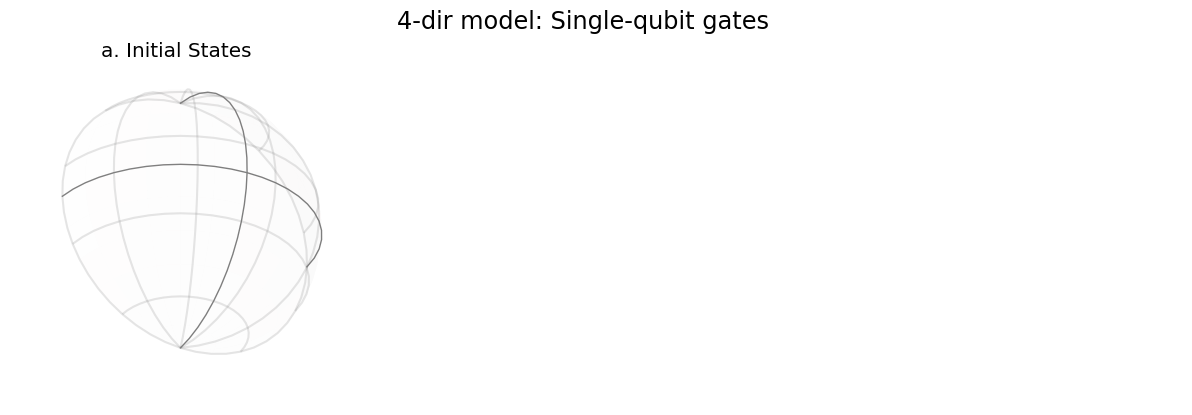

In [8]:
# Combined single qubit plot
fig = plt.figure(figsize=[12, 4], layout='constrained')
fig.suptitle(f"{MODEL_NAME}: Single-qubit gates", fontsize="xx-large")

subfigs = fig.subfigures(1, 3, wspace=0.05)

# states
subfig = subfigs[0]
subfig.suptitle("a. Initial States", fontsize="x-large")
ax = subfig.add_subplot(1, 1, 1, projection='3d')
plot_points(
    [lambdeval(person >> op) for op in [
        Id(qubit), walks_north, walks_east, walks_south, walks_west
    ]],
    fig=subfig,
    axes=ax,
    colors=["k", "k", "k", "k", "k"],
    annotations=[
        (
            get_bloch_points([lambdeval(person >> op if op != person else person)])[0],
            {"text": get_annotation[op], "fontfamily": "monospace"}
        )
        for op in [person, walks_north, walks_east, walks_south, walks_west]
    ],
)
ax.axis('off')
ax.set_title("a. Initial states", fontsize="x-large")

# Rotations
subfig= subfigs[1]
subfig.suptitle("b. Turns", fontsize="x-large")
for i, op in enumerate([turns_left]): #, turns_around, turns_right]):
    print(get_text[op])
    display_1q_rotation(
        op,
        lambdeval=lambdeval,
        figure=subfig,
        ax=subfig.add_subplot(1, 1, 1, projection='3d'),
        title=f"b. ${get_text[op]}$",
        title_kwargs={"fontfamily": "monospace"},
        # steps=10*(i+1),
        steps=20,
        # as_surface=True,
    )


# Axioms
subfig = subfigs[2]
subfig.suptitle("c. Rotation Axioms", fontsize="x-large")
display_1q_rotation(
    turns_left >> turns_left >> turns_left >> turns_left,
    lambdeval=lambdeval,
    figure=subfig,
    ax=subfig.add_subplot(1, 1, 1, projection='3d'),
    title=r"c. $U(\theta_{left})^4 = Id$",
    title_kwargs={"fontfamily": "monospace"},
    steps=40,
    # as_surface=True,
)

In [ ]:
# Single qubit axioms
fig = plt.figure(figsize=[10, 4], layout='constrained')
fig.suptitle(f"{MODEL_NAME}: Single-qubit axioms", fontsize="xx-large")
subfig = fig
col_a = "#FC8469" #"#D841A8"
col_b = "#782FB0" #"#00108C"

steps = 10
for i, (op1, op2, op3) in enumerate([
    (walks_north, walks_south, turns_around),
    (walks_east, walks_west, turns_around),
    (walks_west, walks_north, turns_left),
]):
    ax = subfig.add_subplot(1, 3, i+1, projection='3d')
    diags = [
        person >> op1,
        person >> op2 >> op3,
        person >> op2
    ]
    point_arc = [
        torch.einsum(eigenteroterpolate(lambdeval(op3), step / steps), [0, 1], lambdeval(person >> op2), [0], [1])
        for step in range(steps + 1)
    ]

    title = f"{['a', 'b', 'c'][i]}. |" + get_text[op1] + r"⟩ = $U(\theta_{" + get_text[op3] + r"})$|" + get_text[op2] + "⟩"

    plot_points(
        [lambdeval(diag) for diag in diags],
        annotations=[
            (
                p,
                {"text": text, "fontfamily": "monospace", "color": col}
            )
            for p, text, col in [
                (get_bloch_points([lambdeval(person >> op1)])[0], get_annotation[op1], col_a),
                ([0,0,0], "", "k"),
                (get_bloch_points([lambdeval(person >> op2)])[0], get_annotation[op2], col_b)
            ]
        ],
        fig=subfig,
        axes=ax,
        colors=[col_a, "k", col_b],
        arcs=[
            (start, end, {"fmt": col_b})
            for j, (start, end) in enumerate(zip(point_arc[:-1], point_arc[1:]))
        ] + [
            (start, end, {"fmt": ("#000000%02x" % round((j) / (steps) * 255))})
            for j, (start, end) in enumerate(zip(point_arc[:-1], point_arc[1:]))
        ],
        vectors=[lambdeval(diag) for diag in diags[:-1]],
        vector_colors=[col_a, "k"],
    )
    ax.axis('off')
    ax.set_title(title, fontsize="x-large")

### 2 qubit states.

In [ ]:
remote_preps = get_remote_prep_states(20)
remote_prep_cols = get_sphere_colours(get_bloch_points(remote_preps))

marker_vectors = get_remote_prep_marker_states()
marker_cols = get_sphere_colours(get_bloch_points(marker_vectors))

In [ ]:
fig = plt.figure(figsize=[7, 4], layout='constrained')
fig.suptitle("a. Reference colours", fontsize="xx-large")

ax1 = fig.add_subplot(1, 2, 1, projection='3d')
plot_points(
    remote_preps,
    fig=fig,
    axes=ax1,
    colors=remote_prep_cols,
    vectors=marker_vectors,
    vector_colors=marker_cols,
    axis_labels=False,
)
ax1.axis('off')
ax1.set_title(r"Reference states $|\psi⟩$")

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
plot_points(
    [],
    fig=fig,
    axes=ax2,
    # colors=remote_prep_cols,
    vectors=marker_vectors,
    vector_colors=marker_cols,
    axis_labels=False,
    annotations=[
        (
            p,
            {
                "text": label,
                "horizontalalignment": "center",
                "verticalalignment": "center",
                "color": col,
            }
        )
        for p, col, label in zip([
            # z
            [0, 0, 1.15],
            [0, 0, -1.35],
            # x
            [1.5, 0, 0],
            [-2, 0, 0],
            # y
            [0, 1.2, 0],
            [0, -1.4, 0],
        ], marker_cols[:4] + ["g", marker_cols[-1]], [
            r'$|\,0\,\rangle$',
            r'$|\,1\,\rangle$',
            r'$|+\rangle$',
            r'$|-\rangle$',
            r'$|\,i\,\rangle$',
            r'$|-i\,\rangle$',
        ])
    ]
)
ax2.axis('off')
ax2.set_title(r"Reference points $|\phi⟩$")

In [ ]:
# Follows
fig = plt.figure(figsize=[16, 9.5], layout='constrained')
subfigs = fig.subfigures(4, 4, wspace=0.07, hspace=0.07)

fig.suptitle(f"{MODEL_NAME}: follows", fontsize="xx-large")
n_state_samples = 30

for i, op1 in enumerate([walks_south, walks_north, walks_east, walks_west]):
    for j, op2 in enumerate([walks_south, walks_north, walks_east, walks_west]):
        subfig = subfigs[i][j]
        subtitle = f"|{get_text[op1]}, {get_text[op2]}⟩"
        diag = person @ person >> op1 @ op2 >> follows

        display_2q_state(
            diag,
            lambdeval=lambdeval,
            figure=subfigs[i][j],
            n_samples=n_state_samples,
            title=subtitle
        )

In [ ]:
fig = plt.figure(figsize=[14, 4], layout='constrained')
subfigs = fig.subfigures(1, 2, wspace=0.07)

fig.suptitle(f"{MODEL_NAME}: Questions", fontsize="xx-large")
n_state_samples = 20

for i, op in enumerate([goes_in_same_dir_as, goes_not_in_same_dir_as]):
    subtitle = f"P1 {'goes in same dir as' if op == goes_in_same_dir_as else 'does not go in the same dir as'} P2"
    diag = person @ person >> op @ (Ket(0) >> Discard())

    display_2q_state(
        diag,
        lambdeval=lambdeval,
        figure=subfigs[i],
        n_samples=n_state_samples,
        title=subtitle,
        annotations=[
            (
                [0.4, -0.4, 1.2 if op == "NW" else -1.2],
                {
                    "text": f"|{op}⟩",
                    "fontfamily": "monospace",
                    "horizontalalignment": "center",
                    "color": marker_cols[0] if op == "NW" else marker_cols[1],
                },
            )
            for op in ["NW", "SE"]
        ],
    )